<a href="https://colab.research.google.com/github/egshare/monai_handson/blob/master/segmentation_3d/Lesson03_learn_with_monai_compose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MONAIのTransformを利用したセグメンテーション学習
前回のチュートリアルでは、限られたデータ量を基に、一括でメモリにデータを読み込んで学習を実施しました。そのため、データ拡張やサンプリング制御などのテクニックは導入していませんでした。

しかし、実際の研究や応用においては、大量のデータを効果的に活用してモデルの汎化性能を高めるために、ランダムサンプリングの制御やデータ拡張が重要となります。これらのテクニックを導入することで、モデルの過学習を防ぎ、未見のデータに対する予測精度を向上させることが期待できます。

MONAIのTransform機能は、このようなデータの前処理や拡張を効率的に行うためのフレームワークを提供しています。具体的には、データの読み込み、正規化、水増し等の変換処理を柔軟に組み合わせて実行できる機能を有しています。

今回のチュートリアルでは、MONAIのTransformを使用して、前述のテクニックを実際の学習・推論の流れに取り入れる方法について深く探ることとします。


## 必要なライブラリのインストールを行います

In [ ]:
!pip install -U SimpleITK "monai[ignote, nibabel, torchvision, tdqm]==1.1.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.5 MB/s eta 0:00:00


## 学習用サンプルデータおよび実装表示用関数等のコードをダウンロードして解凍しましょう

In [ ]:
# niiサンプルデータをダウンロード(Lungのセグメンテーション学習用データ約10症例)
# このデータはTCIAのパブリックデータを加工して提供しています
!wget --no-clobber https://www.dropbox.com/s/f6jk58w6tbca31r/nii.zip

File ‘nii.zip’ already there; not retrieving.



In [ ]:
# ダウンロードしたサンプルファイルを解凍します
!unzip -n nii.zip

Archive:  nii.zip


In [ ]:
# 表示用等で実装済み関数を含むPythonファイルをダウンロードして展開します
!rm -r seminor_inc
!rm seminor_inc.zip
!wget -O seminor_inc.zip --no-clobber https://www.dropbox.com/scl/fi/e9ywrbheofjw2k8jxvtmp/seminor_inc.zip?rlkey=5ri24j9n3tc89llvabjg2g2i9&dl=0
!unzip -n seminor_inc.zip

--2023-09-05 11:41:02--  https://www.dropbox.com/scl/fi/e9ywrbheofjw2k8jxvtmp/seminor_inc.zip?rlkey=5ri24j9n3tc89llvabjg2g2i9
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/e9ywrbheofjw2k8jxvtmp/seminor_inc.zip?rlkey=5ri24j9n3tc89llvabjg2g2i9 [following]
--2023-09-05 11:41:02--  https://www.dropbox.com/e/scl/fi/e9ywrbheofjw2k8jxvtmp/seminor_inc.zip?rlkey=5ri24j9n3tc89llvabjg2g2i9
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd85e8123cf89bf3350ac695433.dl.dropboxusercontent.com/cd/0/inline/CDL73BezjvMAzzproVoc0RYYlsGYJdG46PprBXKYSxK_gAM2piSrBpP4WYIbS9sYgjXyrxDzr1l-rhDASZl1WSwM-ITmMDcuhDVbGM4Bm0U2rYaqUC3yYe3W9_EfvhrMrHQ/file# [following]
--2023-09-05 11:41:03--  https://ucd85e8123cf89bf3350ac695433.dl.d

## 必要なライブラリのインポートおよびTransformの準備

In [ ]:
import os, sys, glob
import numpy as np
import cv2
import SimpleITK as sitk
sys.path.append("seminor_inc/")     #seminor_incフォルダ以下のソースコードも参照できるように設定
from my_functions import *
from unet_torch import *
import monai
from monai.utils import first, set_determinism
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Resized,
    RandAffined,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    Transposed,
    SqueezeDimd,
)


## 画素値の設定、学習するサイズと連続スライス数(今回は１スライスずつ)の設定
img_val_min, img_val_max = -1000, 1000
roi_ch = 1
roi_size = 256


####### 学習用Transform #######
train_transforms = Compose(
            [
                # データ読み込み
                LoadImaged(keys=["image", "label"]),
                # ChannelFirstへの変換
                EnsureChannelFirstd(keys=["image", "label"]),
                # 入力画像の画素値のクリップおよび正規化
                ScaleIntensityRanged(
                    keys=["image"], a_min=img_val_min, a_max=img_val_max,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                # ROIデータのクリップおよび正規化
                ScaleIntensityRanged(
                    keys=["label"], a_min=0, a_max=1,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                # 方向変換(R->L, A->P, S->I)
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                # ランダム回転・アフィン変形(遅くなるが汎化性能の向上に寄与する)
                #RandAffined(
                #         keys=['image', 'label'],
                #         mode=('bilinear', 'nearest'),
                #         prob=0.25,
                #         #spatial_size=(roi_size, roi_size, roi_size),
                #         rotate_range=(0, 0, np.pi/36),
                #         scale_range=(0.1, 0.1, 0.1)),
                # ランダムサンプリング(サンプリングサイズやバランスを設定できる)
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(None, None, roi_ch),
                    pos=0.75,
                    neg=0.25,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # ランダム画素値水増し(ノイズ、スムージング、コントラスト)
                RandGaussianNoised(keys=['image'], prob=0.25, mean=0.0, std=0.1),
                RandGaussianSmoothd(keys=['image'], prob=0.25, sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5),
                                    sigma_z=(0.5, 1.5)),
                RandAdjustContrastd(keys=['image'], prob=0.25, gamma=(0.8, 1.2)),
                # 画素値水増し後に再度0-1に画素値をクリップ
                ScaleIntensityRanged(
                    keys=["image"], a_min=0, a_max=1.0,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                # リサイズ
                Resized(keys=["image", "label"], spatial_size=[roi_size, roi_size, None]),
                # 座標軸交換
                Transposed(keys=["image", "label"], indices=(0,3,2,1)),
                # 不要な座標軸の削除(今回は3D画像から2Dスライスを抽出するため)
                SqueezeDimd(keys=["image", "label"], dim=0),
            ]
        )

####### 検証用Transform #######
## 基本的には学習用Transformから水増し用機能を除外したもの ##
## ただし、学習用Transformでは3D画像からランダムに１枚のスライスをサンプリングするのに対し ##
## 検証用Transformでは3D画像全体を取得して検証に用いる ##
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=img_val_min, a_max=img_val_max,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=1,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Resized(keys=["image", "label"], spatial_size=[roi_size, roi_size, None]),
        Transposed(keys=["image", "label"], indices=(0, 3, 2, 1)),
        SqueezeDimd(keys=["image", "label"], dim=0),
    ]
)

## データ読み込み

In [ ]:
## ファイルリストの取得
data_dir = "./nii/"
train_images = sorted(
    glob.glob(os.path.join(data_dir, "*ct.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "*Lung.nii.gz")))

## Dictionary型に変換
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
trainNum = int( len(data_dicts) * 0.8 )  #学習用データ数。今回は8割(10データ中8データ)を学習に使う
testNum = len(data_dicts) - trainNum     #検証用データ数
train_files, val_files = data_dicts[:trainNum], data_dicts[trainNum:]

train_files = train_files * 10

## DataLoader(学習や検証時にモデルにサンプルを供給するクラス)の設定
# キャッシュメモリに応じて0以上～1.0までを設定
# データ数が多い場合、1.0にするとかなりシステムメモリを圧迫するので、適宜調整
cache_rate = 1.0

# 学習用DataLoader
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=cache_rate, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# 検証用DataLoader
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


torch.Size([8, 1, 256, 256]) tensor(0.) tensor(1.) tensor(0.) tensor(1.)


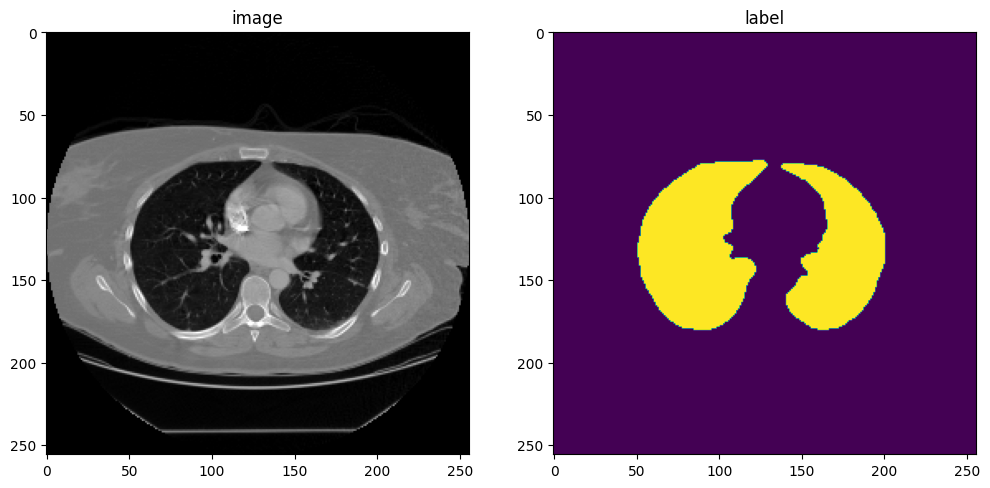

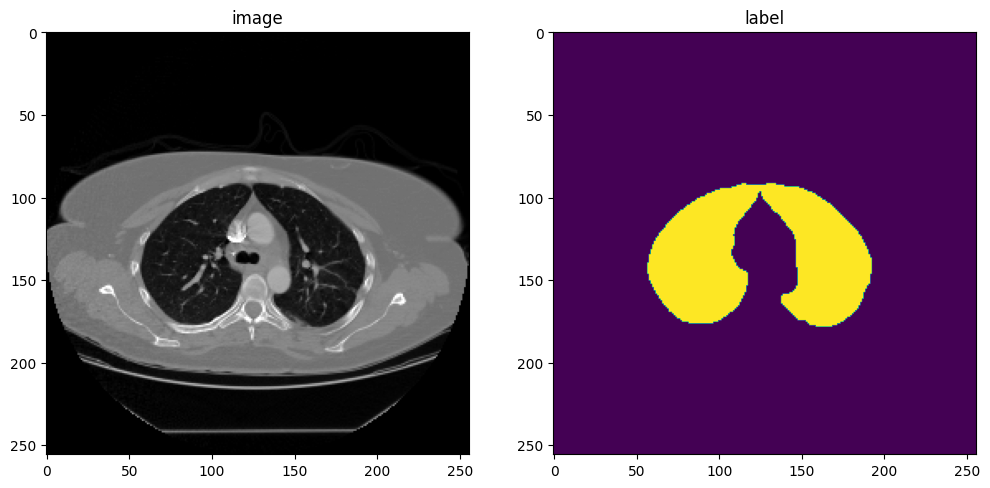

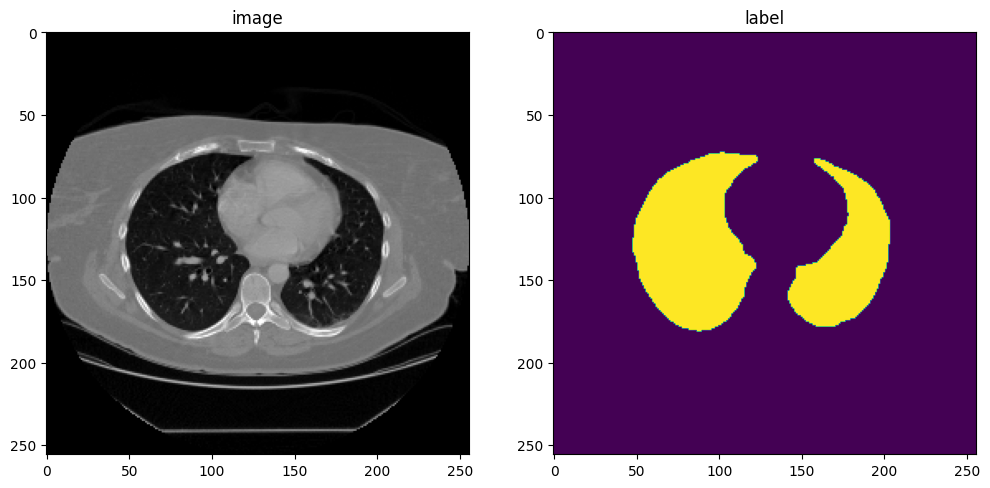

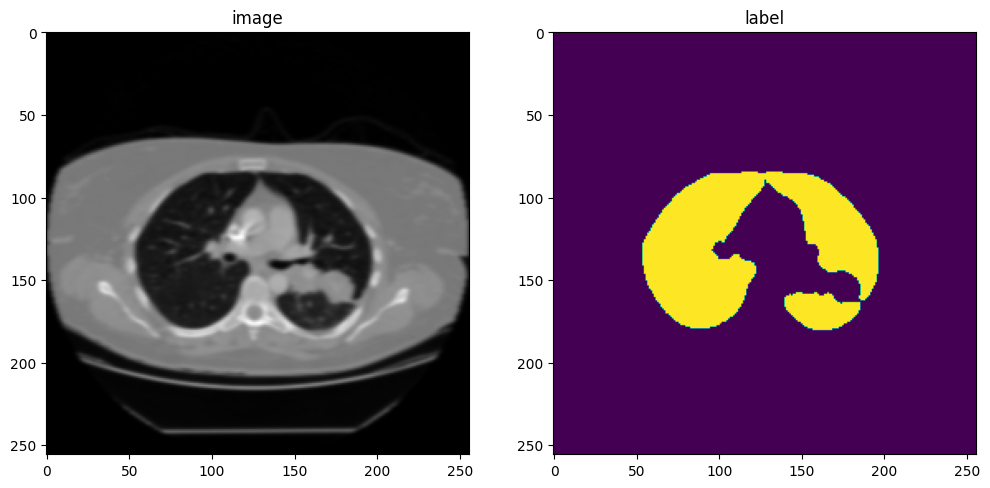

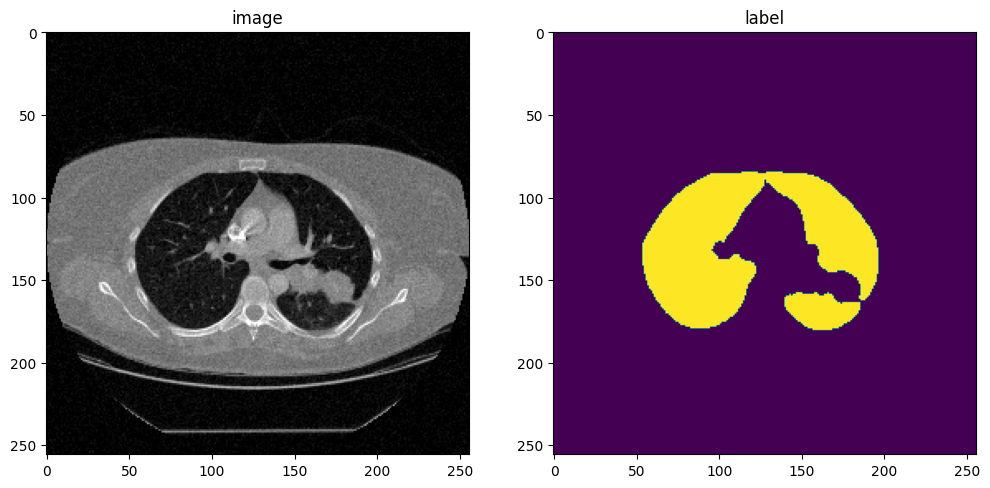

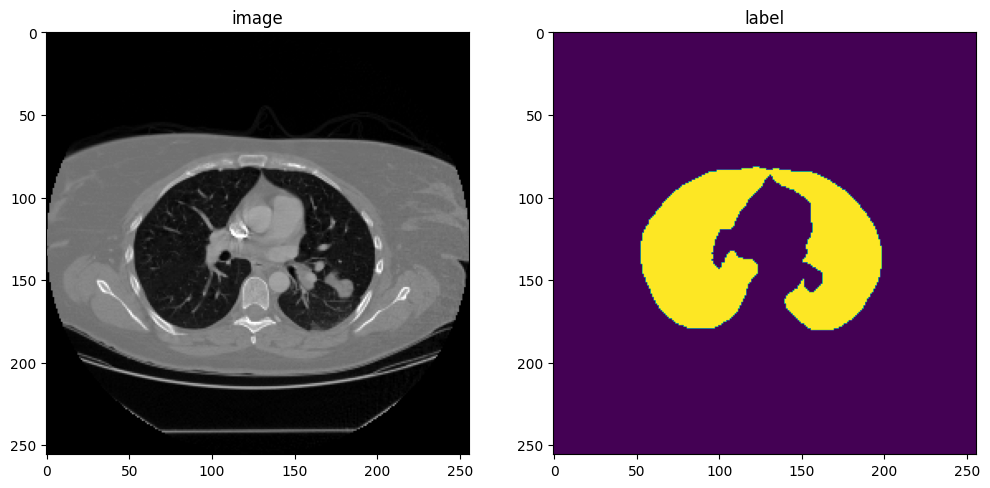

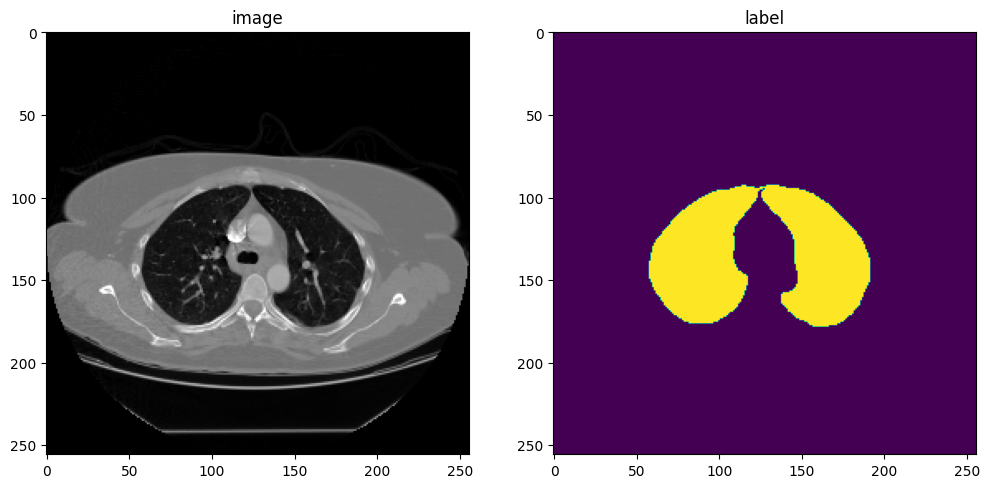

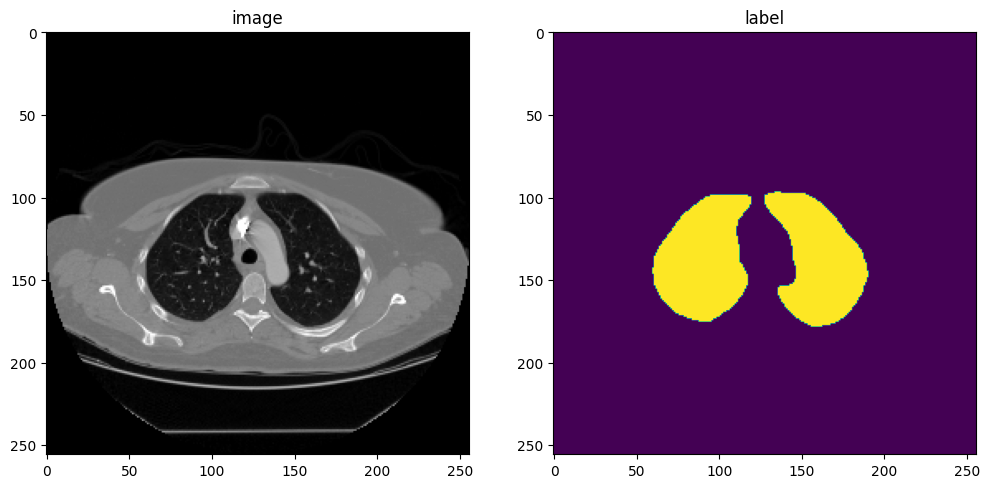

In [ ]:
# 学習用Dataloaderの出力形状を確認
check_data = first(train_loader)
image, label = (check_data["image"], check_data["label"])
print(image.shape, image.min(), image.max(), label.min(), label.max())

# 入力と正解ラベルを表示して確認
import matplotlib.pyplot as plt
for i in range(image.shape[0]):
  plt.figure("check", (12, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(image[i, 0, :, :], cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[i, 0, :, :])
  plt.show()


## 学習実施
Transformを利用した学習を行います。モデルの定義や損失関数は前回のチュートリアルと同じものを利用します。


In [ ]:
####### 損失関数およびモデルの定義 #######
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import monai

# ダイス係数を計算する関数
def dice_coefficient(pred, target):
    smooth = 1e-6
    num = pred.size(0)
    m1 = pred.view(num, -1)
    m2 = target.view(num, -1)
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

# 損失関数
def dice_loss(pred, target):
    return 1. - dice_coefficient(pred, target)

#学習用デバイスを決定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#モデルを読み込み
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

#損失関数はダイス係数(1.0より小さいほど損失大)、オプティマイザーはAdamを利用
criterion = dice_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
####### 学習の実施 #######

def np_dice(pred, target, smooth=1e-08):
    pred = pred.flatten()
    target = target.flatten()

    intersection = np.sum(pred * target)

    dice = ((2.0 * intersection + smooth) / (np.sum(pred) + np.sum(target) + smooth))

    return dice

# 学習したモデルの保存用フォルダを生成
modelDir = "model/"
os.makedirs(modelDir, exist_ok=True)


fromEpoch = 0   #開始エポック
totalEpoch = 50  #終了エポック
steps = 200     #1エポック内の学習回数
batchSize = 9   #1学習あたりのバッチサイズ

#学習済み重みをリロードして、続きから学習する場合
wPath = "model/monai_unet_with_Transform.pth"
if False:
    model.load_state_dict(torch.load(wPath))

for epoch in range(fromEpoch, totalEpoch):
    if True:
        model.train()
        #model.setSingleOutput(False)
        epoch_loss = 0
        step = 0

        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dice_loss(torch.sigmoid(outputs), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if (step+1) % 10 == 0:
              print(f"Epoch {epoch + 1}/{totalEpoch}, Step {step+1}, Loss: {loss.item()}")

        epoch_loss /= step


        torch.save(model.state_dict(), wPath)
        print("")

    #検証
    model.eval()
    with torch.no_grad():
        diceList = []
        for iVal, val_data in enumerate(val_loader):
            val_inputs, val_labels = (
                val_data["image"].to(device),
                val_data["label"].to(device),
            )
            val_inputs = torch.transpose(val_inputs, 0, 1)
            val_labels = torch.transpose(val_labels, 0, 1)
            #print("shape", val_inputs.shape, val_labels.shape)
            # print(val_labels.detach().cpu().numpy().shape)
            # print("***val_data image shape:", val_data["image"].shape)
            win_size = (roi_size, roi_size)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_inputs, win_size, sw_batch_size, model)

            npOut = torch.sigmoid(val_outputs).detach().cpu().numpy()
            npOut[npOut >= 0.5] = 1.0
            npOut[npOut < 0.5] = 0
            dice = np_dice(npOut, val_labels.detach().cpu().numpy())
            diceList.append(dice)
            print(iVal, f"Dice scores: {dice}")
        print(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}, average val dice: {np.mean(diceList):.4f}")




## 学習済みモデルの検証と推論結果の表示

In [ ]:
import matplotlib.pyplot as plt

## テストデータで推論して検証する
wPath = "model/monai_unet_with_Transform.pth"
model.load_state_dict(torch.load(wPath))
model.eval()
with torch.no_grad():
    diceList = []
    for iVal, val_data in enumerate(val_loader):
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_inputs = torch.transpose(val_inputs, 0, 1)
        val_labels = torch.transpose(val_labels, 0, 1)

        # 推論実行
        # monaiのsliding_window_inference関数を使えば、ボリューム全体に対してwin_sizeにしたがって逐一推論実行した結果を返してくれる
        win_size = (roi_size, roi_size)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_inputs, win_size, sw_batch_size, model)

        # 学習時では、損失関数に入力する前にモデル出力を0～1.0に正規化しているので、
        # 推論時も同様な正規化を行う
        val_outputs = torch.sigmoid(val_outputs)

        # さらに、後処理として0.5を閾値としてラベルを2値化する
        val_outputs[val_outputs >= 0.5] = 1.0
        val_outputs[val_outputs < 0.5] = 0

        # Dice係数を計算
        tDice = dice_coefficient(val_outputs, val_labels)

        diceList.append(tDice.item())
        print(iVal, f"Dice scores: {diceList[-1]}")

        if True:
            # PytorchのTensorからnumpyに変換
            val_inputs = val_inputs.detach().cpu().numpy()
            val_labels = val_labels.detach().cpu().numpy()
            val_outputs = val_outputs.detach().cpu().numpy()
            print(val_inputs.shape)
            # 実装済み表示用関数で推論結果を表示する
            spacingX, spacingY, spacingZ = 1.0, 1.0, 1.0
            browse_result(val_inputs[:,0], val_labels[:,0], val_outputs[:,0], aspect=spacingY/spacingX)

print(diceList)
print("val mean dice", np.mean(diceList))

0 Dice scores: 0.9886758327484131
(140, 1, 256, 256)


interactive(children=(IntSlider(value=69, description='i', max=139), Output()), _dom_classes=('widget-interact…

1 Dice scores: 0.9849791526794434
(145, 1, 256, 256)


interactive(children=(IntSlider(value=72, description='i', max=144), Output()), _dom_classes=('widget-interact…

[0.9886758327484131, 0.9849791526794434]
val mean dice 0.9868274927139282
